In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import pmdarima as pm
import torch

In [3]:
df = pd.read_csv("test_ILI.csv")

df.sort_index(inplace=True)

# Reindex the DataFrame to fill in missing dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_reindexed = df.reindex(all_dates)

# Fill missing values with 0
df_filled = df_reindexed.fillna(0)

# Now df_filled can be used for further analysis or modeling
df_filled
len(df)

7664

<Axes: >

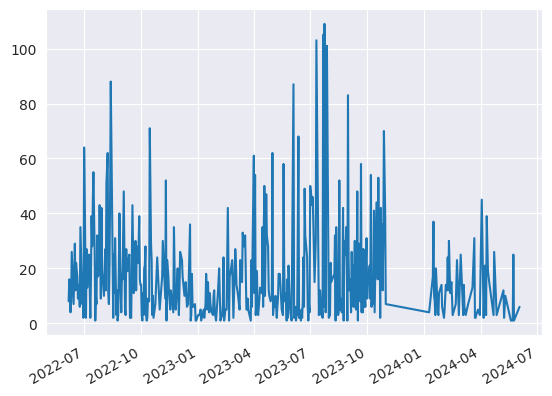

In [4]:
df['Date of Encounter'] = pd.to_datetime(df['Date of Encounter'])
df['Date of Encounter'].value_counts().sort_index().plot() 

In [5]:
year = df['Date of Encounter'].dt.isocalendar().year.astype(str)
week = df['Date of Encounter'].dt.isocalendar().week.astype(str)
day  = df['Date of Encounter'].dt.dayofyear.astype(str)

df['year'] = year
df['week'] = week
df['year-week'] = year + "-" + week
df['year-week-day'] = year + "-" + week + "-" + day

def convert_to_date(year_week):
    year, week = map(int, year_week.split('-'))
    # Convert week to month assuming each month has 4 weeks
    month = int((week - 1) / 4) + 1
    return f'{year}-W{week:02d}-DAY{month:02d}'

def convert_to_date_day(year_week_day):
    year, week, day = map(int, year_week_day.split('-'))
    # Convert week to month assuming each month has 4 weeks
    month = int((week - 1) / 4) + 1
    return f'{year}-W{week:02d}-MONTH{month:02d}-DAY{day}'

In [57]:
baseline_df = df[df['year'].isin(['2022'])]

In [58]:
data = baseline_df['Date of Encounter'].value_counts().sort_index().reset_index()
data.columns = ['Date of Encounter','count']
data

,Date of Encounter,count
0,2022-06-06 00:00:00+08:00,8
1,2022-06-07 00:00:00+08:00,16
2,2022-06-09 00:00:00+08:00,4
3,2022-06-10 00:00:00+08:00,8
4,2022-06-11 00:00:00+08:00,26
...,...,...
145,2022-12-24 00:00:00+08:00,6
146,2022-12-27 00:00:00+08:00,7
147,2022-12-28 00:00:00+08:00,1
148,2022-12-29 00:00:00+08:00,1


In [59]:
sorted_data = data.sort_values(by='Date of Encounter', ascending=True, axis=0)
sorted_data["Date of Encounter"] = sorted_data["Date of Encounter"].dt.strftime('%Y-%m-%d')
sorted_data.set_index('Date of Encounter', inplace=True)
all_dates = pd.date_range(start=sorted_data.index.min(), end=sorted_data.index.max(), freq='D').strftime('%Y-%m-%d')
sorted_data_reindexed = sorted_data.reindex(all_dates)
sorted_data_filled = sorted_data_reindexed.fillna(0)
sorted_data_filled.index

Index(['2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
       '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15',
       ...
       '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27',
       '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31', '2023-01-01'],
      dtype='object', length=210)

In [60]:
def fill_values(data, filled_data):
    data_date = data.index
    filled_data_date = filled_data.index
    counter = 0
    for i in range(len(filled_data)):
        print(filled_data_date[i], data_date[counter])
        if filled_data_date[i] == data_date[counter]:
            filled_data.iloc[i] = data.iloc[counter]
            counter += 1
    
    return filled_data

In [61]:
sorted_data.index

Index(['2022-06-06', '2022-06-07', '2022-06-09', '2022-06-10', '2022-06-11',
       '2022-06-13', '2022-06-14', '2022-06-16', '2022-06-17', '2022-06-18',
       ...
       '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',
       '2022-12-24', '2022-12-27', '2022-12-28', '2022-12-29', '2023-01-01'],
      dtype='object', name='Date of Encounter', length=150)

In [62]:
filled_data =fill_values(sorted_data, sorted_data_filled)
filled_data

2022-06-06 2022-06-06
2022-06-07 2022-06-07
2022-06-08 2022-06-09
2022-06-09 2022-06-09
2022-06-10 2022-06-10
2022-06-11 2022-06-11
2022-06-12 2022-06-13
2022-06-13 2022-06-13
2022-06-14 2022-06-14
2022-06-15 2022-06-16
2022-06-16 2022-06-16
2022-06-17 2022-06-17
2022-06-18 2022-06-18
2022-06-19 2022-06-20
2022-06-20 2022-06-20
2022-06-21 2022-06-21
2022-06-22 2022-06-22
2022-06-23 2022-06-23
2022-06-24 2022-06-24
2022-06-25 2022-06-25
2022-06-26 2022-06-27
2022-06-27 2022-06-27
2022-06-28 2022-06-28
2022-06-29 2022-06-29
2022-06-30 2022-06-30
2022-07-01 2022-07-01
2022-07-02 2022-07-02
2022-07-03 2022-07-04
2022-07-04 2022-07-04
2022-07-05 2022-07-05
2022-07-06 2022-07-06
2022-07-07 2022-07-07
2022-07-08 2022-07-08
2022-07-09 2022-07-09
2022-07-10 2022-07-11
2022-07-11 2022-07-11
2022-07-12 2022-07-12
2022-07-13 2022-07-13
2022-07-14 2022-07-14
2022-07-15 2022-07-15
2022-07-16 2022-07-16
2022-07-17 2022-07-18
2022-07-18 2022-07-18
2022-07-19 2022-07-19
2022-07-20 2022-07-20
2022-07-21

,count
2022-06-06,8.0
2022-06-07,16.0
2022-06-08,0.0
2022-06-09,4.0
2022-06-10,8.0
...,...
2022-12-28,1.0
2022-12-29,1.0
2022-12-30,0.0
2022-12-31,0.0


In [63]:
data

,Date of Encounter,count
0,2022-06-06 00:00:00+08:00,8
1,2022-06-07 00:00:00+08:00,16
2,2022-06-09 00:00:00+08:00,4
3,2022-06-10 00:00:00+08:00,8
4,2022-06-11 00:00:00+08:00,26
...,...,...
145,2022-12-24 00:00:00+08:00,6
146,2022-12-27 00:00:00+08:00,7
147,2022-12-28 00:00:00+08:00,1
148,2022-12-29 00:00:00+08:00,1


In [64]:
data.columns = ['Date of Encounter','count']
data['Date of Encounter'] = pd.to_datetime(data['Date of Encounter'])
year = data['Date of Encounter'].dt.isocalendar().year.astype(str)
week = data['Date of Encounter'].dt.isocalendar().week.astype(str)
day  = data['Date of Encounter'].dt.dayofyear.astype(str)

data['year'] = year
data['week'] = week
data['year-week'] = year + "-" + week
data['year-week-day'] = year + "-" + week + "-" + day


len(data["year-week-day"].unique())

150

In [65]:
data['week'] = data['year-week'].apply(convert_to_date)
data.set_index('week', inplace=True)

data.head()

,Date of Encounter,count,year,year-week,year-week-day
week,,,,,
2022-W23-DAY06,2022-06-06 00:00:00+08:00,8,2022,2022-23,2022-23-157
2022-W23-DAY06,2022-06-07 00:00:00+08:00,16,2022,2022-23,2022-23-158
2022-W23-DAY06,2022-06-09 00:00:00+08:00,4,2022,2022-23,2022-23-160
2022-W23-DAY06,2022-06-10 00:00:00+08:00,8,2022,2022-23,2022-23-161
2022-W23-DAY06,2022-06-11 00:00:00+08:00,26,2022,2022-23,2022-23-162


(array([19143.66666667, 19173.66666667, 19204.66666667, 19235.66666667,
        19265.66666667, 19296.66666667, 19326.66666667, 19357.66666667]),
 [Text(19143.666666666668, 0, '2022-06'),
  Text(19173.666666666668, 0, '2022-07'),
  Text(19204.666666666668, 0, '2022-08'),
  Text(19235.666666666668, 0, '2022-09'),
  Text(19265.666666666668, 0, '2022-10'),
  Text(19296.666666666668, 0, '2022-11'),
  Text(19326.666666666668, 0, '2022-12'),
  Text(19357.666666666668, 0, '2023-01')])

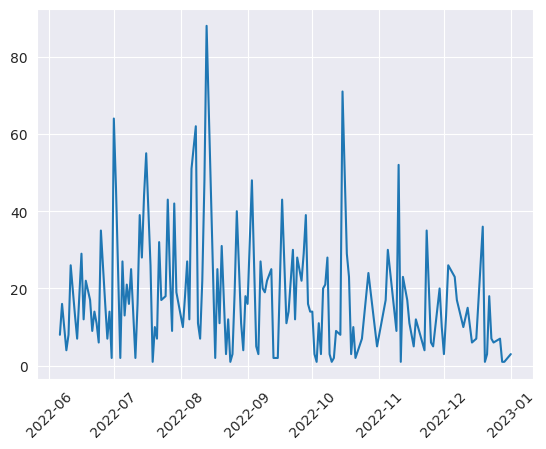

In [66]:
plt.plot(data["Date of Encounter"],data['count'])
plt.xticks(rotation=45)

In [67]:
# Ensure 'Date of Encounter' is in datetime format and set as index
#data['Date of Encounter'] = pd.to_datetime(data['Date of Encounter'])
#data.set_index('Date of Encounter', inplace=True)

# If the frequency of your data is daily, ensure the index has a daily frequency
data

,Date of Encounter,count,year,year-week,year-week-day
week,,,,,
2022-W23-DAY06,2022-06-06 00:00:00+08:00,8,2022,2022-23,2022-23-157
2022-W23-DAY06,2022-06-07 00:00:00+08:00,16,2022,2022-23,2022-23-158
2022-W23-DAY06,2022-06-09 00:00:00+08:00,4,2022,2022-23,2022-23-160
2022-W23-DAY06,2022-06-10 00:00:00+08:00,8,2022,2022-23,2022-23-161
2022-W23-DAY06,2022-06-11 00:00:00+08:00,26,2022,2022-23,2022-23-162
...,...,...,...,...,...
2022-W51-DAY13,2022-12-24 00:00:00+08:00,6,2022,2022-51,2022-51-358
2022-W52-DAY13,2022-12-27 00:00:00+08:00,7,2022,2022-52,2022-52-361
2022-W52-DAY13,2022-12-28 00:00:00+08:00,1,2022,2022-52,2022-52-362


In [68]:
model = pm.auto_arima(
    data['count'],
    start_p = 1,
    start_q = 1,
    max_p = 12,
    max_q = 12,
    seasonal = True,
    trace = True,
    m = 7,
    stationary= True
)

# You can then use results to make predictions, analyze the model, etc.

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=1253.725, Time=1.91 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1251.664, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1251.975, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1251.322, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1376.997, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=1249.569, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=1251.344, Time=0.16 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=1253.254, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=1250.025, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=1250.656, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1250.161, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=1252.025, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[7]             : AIC=1328.381, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[7] intercept
Total fit time: 2.729 seconds


AR(2) I(1) MA(1)
[y_(t+1)+y_(t)]/2

In [71]:
import numpy as np
import pandas as pd

def detect_changes(df, threshold, arima_model):
    # Aggregate duplicates by summing counts
    df = df.groupby('year-week-day').agg({'count': 'sum'}).reset_index()

    # Convert 'year-week-day' to datetime and set as index
    df['Date'] = pd.to_datetime(df['year-week-day'], format='%Y-W%W-%w', errors='coerce')
    df.set_index('Date', inplace=True)
    df.drop(columns=['year-week-day'], inplace=True)

    # Drop duplicate indices if any
    df = df[~df.index.duplicated(keep='first')]

    # Recalculate mean and standard deviation
    mean_ = df['count'].mean()
    dev_ = df['count'].std()
    
    # Initialize warning columns and C1, C2
    df["warning_cusum"] = 0
    df["warning_c1"] = 0
    df["warning_c2"] = 0
    df["warning_arima"] = 0

    df['C1'] = 0.0
    df['C2'] = 0.0

    prev_idx = None

    for i, row in df.iterrows():
        change_ = max(0, row["count"] - mean_)

        # Update cusum warning
        df.at[i, "warning_cusum"] = 1 if change_ > threshold * dev_ else 0

        # Calculate C1 and C2
        if prev_idx is not None:
            c1 = df.at[prev_idx, 'C1']
            c2 = df.at[prev_idx, 'C2']
        else:
            c1 = 0
            c2 = 0

        df.at[i, 'C1'] = max(0, row["count"] - mean_ + c1)
        df.at[i, 'C2'] = max(0, mean_ - row["count"] + c2)

        # Detect changes for C1 and C2
        df.at[i, 'warning_c1'] = 1 if df.at[i, 'C1'] > threshold * dev_ else 0
        df.at[i, 'warning_c2'] = 1 if df.at[i, 'C2'] > threshold * dev_ else 0

        prev_idx = i

    # Ensure ARIMA model prediction matches df length
    try:
        predicted = arima_model.predict_in_sample()
        # Ensure predictions length matches df length
        if len(predicted) != len(df):
            raise ValueError("Length of ARIMA predictions does not match the DataFrame length.")
        df['predicted'] = predicted
    except Exception as e:
        print(f"Error in ARIMA prediction: {e}")
        df['predicted'] = np.nan  # Handle missing predictions

    # Calculate residuals and standard deviation
    residuals = df['count'] - df['predicted']
    residual_std = np.std(residuals)

    # Detect changes for ARIMA model
    df['warning_arima'] = (residuals > threshold * residual_std).astype(int)

    return df


In [72]:
data_ = detect_changes(data, threshold = 2, arima_model = model)

Error in ARIMA prediction: Length of ARIMA predictions does not match the DataFrame length.


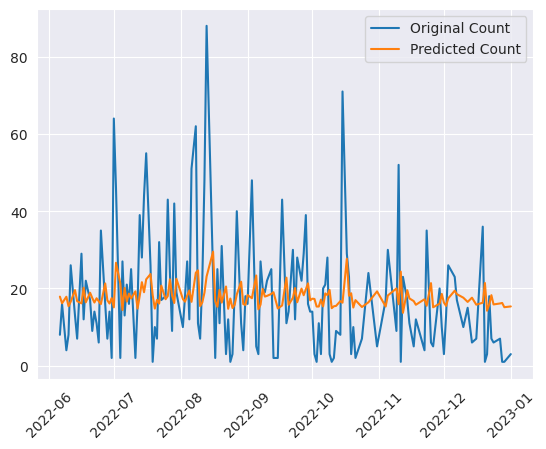

In [41]:
plt.plot(data["Date of Encounter"],data['count'])
plt.plot(data["Date of Encounter"],data['predicted'])
plt.xticks(rotation=45)
plt.legend(['Original Count', 'Predicted Count'])


In [56]:
data.columns

Index(['Date of Encounter', 'count', 'year', 'year-week', 'warning_cusum',
       'warning_c1', 'warning_c2', 'warning_arima', 'C1', 'C2', 'predicted'],
      dtype='object')

In [45]:
data_.describe()

,count,warning_arima,C1,C2,predicted
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,17.906667,0.046667,209.795911,58.069778,17.897167
std,15.537937,0.211631,106.765135,64.088876,2.741652
min,1.000000,0.000000,8.093333,0.000000,13.693546
25%,7.000000,0.000000,135.090000,11.386667,15.955312
50%,14.000000,0.000000,225.173333,34.066667,17.317181
75%,25.000000,0.000000,308.786667,84.040000,19.028773
max,88.000000,1.000000,341.920000,268.493333,29.516653


In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -621.784
Date:                Mon, 22 Jul 2024   AIC                           1249.569
Time:                        17:42:33   BIC                           1258.601
Sample:                             0   HQIC                          1253.238
                                - 150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.8803      2.010      8.897      0.000      13.941      21.820
ma.L1          0.1793      0.071      2.511      0.012       0.039       0.319
sigma2       233.3136     24.511      9.519      0.000     185.273     281.354
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                96.02
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             1.46
Prob(H) (two-sided):                  0.87   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
def plot_changes(df, warnings):
    plt.figure(figsize=(10, 6))

    plt.plot(df['count'], label='Count')

    colors = {'warning_cusum': 'red', 'warning_c1': 'green', 'warning_c2': 'purple', 'warning_arima': 'blue'}
    labels = {'warning_cusum': 'Change detected by Cumulative Sum Control', 'warning_c1': 'Change detected by C1', 'warning_c2': 'Change detected by C2', 'warning_arima': 'Change detected by ARIMA'}
    markers = {'warning_cusum': 'o', 'warning_c1': 'o', 'warning_c2': 's', 'warning_arima': 'x'}

    for warning in warnings:
        change_points = df[df[warning]==1]
        plt.scatter(change_points.index, change_points['count'], color=colors[warning], label=labels[warning], marker=markers[warning])

    # Set the x-ticks to the weeks where a change was detected by the selected warnings
    change_points_indices = set()
    for warning in warnings:
        change_points_indices = change_points_indices.union(set(df[df[warning]==1].index.values))
    plt.xticks(list(change_points_indices))

    #plt.xticks([])

    # Add labels and title
    plt.xlabel('Week')
    plt.ylabel('Count')
    plt.title('Influenza-Like Illnesses Warning Levels')

    # Add a legend
    plt.legend()

    plt.xticks(rotation=75)

    # Display the plot
    plt.show()

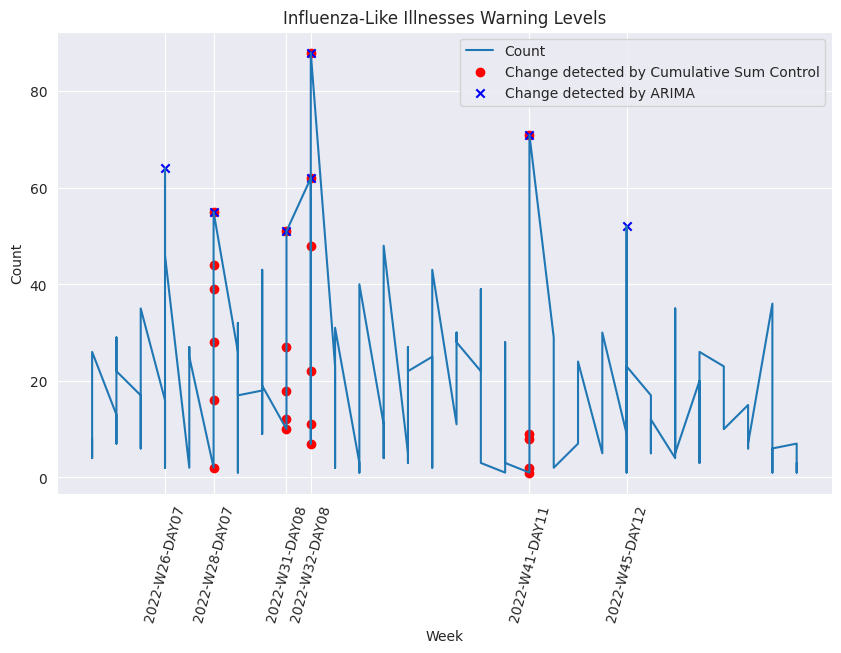

In [48]:
# Use the function
plot_changes(data_, ['warning_cusum', 'warning_arima'])